In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as sc
from scipy.interpolate import interp1d

# Exercise 1 (Bruteforce T=2)

In [25]:
# struct like object
class struct():
    pass

def get_id_of_maxval(array):
    """array : np.array object"""
    return np.argmax(array)

In [161]:
# Setup
param = struct()
param.alpha = 0.5
param.beta = 0.9
param.t = 2
param.u = lambda x, par: x**par.alpha 

In [162]:
M = 5

In [165]:
# setup
Vstar = - np.inf
Cstar = [np.nan for _ in range(param.t)]

for C1 in range(0, M + 1):
    # evaluate 
    V = param.u(C1, param) + param.beta * param.u(M-C1, param) 
    if V > Vstar:
        Vstar = V
        Cstar[0] = C1
        Cstar[1] = M - C1

print('Vstar', Vstar)
print('Cstar', Cstar)


Vstar 3.004843013704663
Cstar [3, 2]


# Exercise 2 (Bruteforce T=3)

In [245]:
# Setup
param = struct()
param.alpha = 0.5
param.beta = 0.9
param.t = 3
param.u = lambda x, par: x**par.alpha 

In [246]:
M = 5

In [247]:
# setup
Vstar = - np.inf
Cstar = [np.nan for _ in range(param.t)]

In [248]:
for C2 in range(0, M+1):
    for C1 in range(0, M-C2): #here note that it has a variable length for end point
        
        V = param.u(C2,param) + param.beta * param.u(C1,param) + (param.beta**2)*param.u(M-C1-C2,param)
        
        if V > Vstar:
            Vstar = V
            Cstar[0] = C2
            Cstar[1] = C1
            Cstar[2] = M - C1 - C2
            
print('Vstar',Vstar)
print('Cstar',Cstar)
        

Vstar 3.4970057685088807
Cstar [2, 2, 1]


# Backwards induction (T=3)

In [263]:
# Setup
param = struct()
param.alpha = 0.5
param.beta = 0.9
param.T = 10
param.u = lambda x, par: x**par.alpha 

In [264]:
M = 5

In [265]:
def find_V(M, Vstar_t, Vstar_next, Cstar_t, param):
    
    for m in range(0, M+1):
        Vstar_t[m] = -np.inf

        for Ct in range(m+1):
            i_next = m - Ct
            V = np.sqrt(Ct) + param.beta * Vstar_next[i_next]
            if V > Vstar_t[m]:
                Vstar_t[m] = V
                Cstar_t[m] = Ct
    return Vstar_t, Cstar_t


In [266]:
Vstar, Cstar = dict(), dict()

Vstar[param.T - 1] = param.u(np.arange(M+1), param)
Cstar[param.T - 1] = np.arange(M+1)

for t in reversed(range(param.T - 1)):
    
    #print('this t', t)
    Vstar[t] = np.ones(M+1)*(np.nan)
    Cstar[t] = np.ones(M+1)*(np.nan)
    
    Vstar[t], Cstar[t] = find_V(M, Vstar[t], Vstar[t+1] , Cstar[t], param)
    


In [267]:
def get_ct(Vstar_t, M, C_acc):
    consumption_limit = int(M - C_acc)
    idx = np.argmax(Vstar_t[0: consumption_limit + 1]) #remember index error needs plus 1
    return idx

In [268]:
consumption_path = dict()
C_acc = 0
for t in sorted(Cstar.keys()):
    i = get_ct(Vstar[t], M, C_acc) #np.argmax get's id of highest value
    Ct = Cstar[t][i]
    C_acc = C_acc + Ct
    consumption_path[t] = Ct


In [285]:
res = pd.DataFrame(zip(*consumption_path.items())).T
res.columns = ['time', 'consumption']
res.set_index('time')

,consumption
time,
0.0,1.0
1.0,1.0
2.0,1.0
3.0,1.0
4.0,1.0
5.0,0.0
6.0,0.0
7.0,0.0
8.0,0.0


# Exercise 2

Now with shock of probability $\pi$

In [152]:
par = struct()
par.alpha = 0.5
par.beta = 0.9
par.pi = 0.5
par.T = 10
par.u = lambda x, par: x**par.alpha

In [153]:
M = 10

In [154]:
Vstar, Cstar = dict(), dict()

In [155]:
def calc_V(par, Ct, Vstar_next, Vstar_next_plus):
    EV = (1 - par.pi) * Vstar_next + par.pi * Vstar_next_plus # here
    V = par.u(Ct, par) + par.beta*EV
    return V

def find_V(M, t, Vstar, Cstar, par):
    for m in range(M + t + 1):
        
        Vstar[t][m] = - np.inf
        
        for Ct in range(0, m):
            
            if t == par.T:
                V = par.u(C, par)
            
            
            else:
                i_next, i_next_plus = m - Ct, m - Ct + 1  
                V = calc_V(par, Ct, Vstar[t+1][i_next], Vstar[t+1][i_next_plus])

            if V > Vstar[t][m]:
                Vstar[t][m] = V
                Cstar[t][m] = Ct
 
    return Vstar[t], Cstar[t] 
        

In [156]:
Vstar, Cstar = dict(), dict()

Cstar[par.T] = np.arange(M + par.T + 1) # +1 because of 20 items is possible to be consumed in last period
Vstar[par.T] = par.u(Cstar[par.T], par)

for t in reversed(range(1, par.T)):
    
    Vstar[t] = np.ones(M+1 + par.T)*(np.nan)
    Cstar[t] = np.ones(M+1 + par.T)*(np.nan)
    
    Vstar[t], Cstar[t] = find_V(M, t, Vstar, Cstar, par)
    


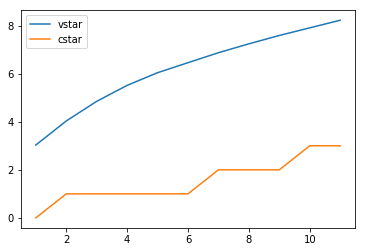

In [157]:
plt.plot(Vstar[1],label='vstar')
plt.plot(Cstar[1], label='cstar')
plt.legend()

# Exercise 3

In [8]:
def f(x):
    return (x-3)**2

x_true = np.linspace(0,6, 100)
f_true = f(x_true)
x_known = np.array([1, 2, 3, 4, 5])
f_known = f(x_known)

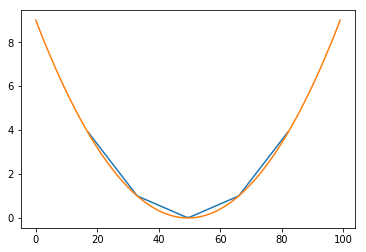

In [9]:
interpolated = sc.griddata(x_known, f_known, x_true, method='linear')
plt.plot(interpolated, label='interpolated')
plt.plot(f_true)


In [21]:
f = interp1d(x_known, f_known, bounds_error=False, fill_value='extrapolate')
f(10)

array(19.)

# Exercise 3 - continued

In [59]:
par = struct()
par.T = 10
par.beta = 0.9
par.alpha = 0.5
par.pi = 0.5
par.M = 5
par.hash_M = 10
par.hash_C = 15
par.grid_M = np.linspace(1, par.M, par.hash_M)
par.u = lambda x, par: x**par.alpha

In [123]:
def interp_v(x, x_grid, y_grid):
    f = interp1d(x_grid, y_grid, bounds_error=False, fill_value='extrapolate')
    return f(x)

def find_V(par, t, Vstar, Cstar):
    
    Vstar_t, Vstar_t1, Cstar_t = Vstar[t], Vstar[t + 1], Cstar[t]
    
    for im in range(0, par.hash_M):
        Vstar_t[im] = - np.inf        
        Mt = par.grid_M[im]
        
        for Ct in np.linspace(0, Mt, par.hash_C): # loops over 

            V = calc_V_for_M(par, Mt, Vstar_t1, Ct)
        
            if im==4 and t ==4:
                print(V)
            if V > Vstar_t[im]:
                
                Vstar_t[im] = V
                Cstar_t[im] = Ct
            
    return Vstar_t, Cstar_t
            
        
def calc_V_for_M(par, Mt, Vstar_t1, Ct):
    
        EV_t1 = par.pi*interp_v(Mt - Ct + 1, par.grid_M, Vstar_t1) + (1 - par.pi)*interp_v(Mt - Ct, par.grid_M, Vstar_t1)
        V = np.sqrt(Ct) + par.beta * EV_t1
        return V

def run_model(par):
    
    #instantiate model
    Vstar, Cstar = dict(), dict()
    
    Cstar[par.T] = np.linspace(0, par.M,par.hash_M) # +1 because of 20 items is possible to be consumed in last period
    Vstar[par.T] = par.u(Cstar[par.T], par)
    
    for t in reversed(range(1, par.T)):
    
        Vstar[t] = np.linspace(0, par.M, par.hash_M)*(np.nan)
        Cstar[t] = np.linspace(0, par.M, par.hash_M)*(np.nan)

        Vstar[t], Cstar[t] = find_V(par, t, Vstar, Cstar)
    
    return Vstar, Cstar

In [124]:
Vstar, Cstar = run_model(par)

3.726654282007105
4.084867135838573
4.181234680519073
4.233231086311797
4.261344988108217
4.274840492936741
4.27579986718222
4.26880053098302
4.254104930891728
4.2340530627799
4.209475507427992
4.1809480381154955
4.149164027558233
4.114073801946455
4.076603370424158


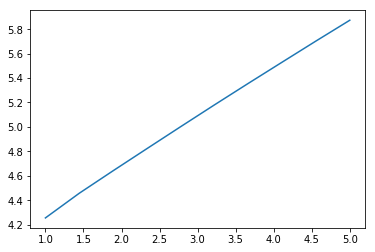

In [127]:
plt.plot(par.grid_M, Vstar[2])

In [111]:
par.grid_M

array([1.        , 1.44444444, 1.88888889, 2.33333333, 2.77777778,
       3.22222222, 3.66666667, 4.11111111, 4.55555556, 5.        ])

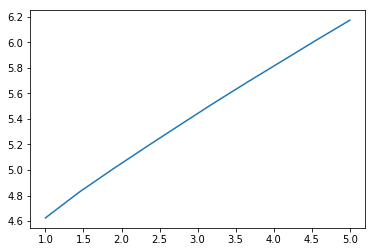

In [130]:
plt.plot(par.grid_M, Vstar[1])